# Informe Final

## 1. Introducción

### Contexto del Problema
El Banco de Comisiones Infinitas (BCI), liderado por Ignacio Yacurro, busca desarrollar un modelo de riesgo crediticio para predecir la probabilidad de mora de los clientes. El objetivo es maximizar los ingresos por intereses mientras se minimizan las pérdidas por préstamos incobrables.

### Descripción del Problema
- **Qué se busca predecir**: La probabilidad de morosidad de los clientes.
- **Datos**: Incluyen información relevante sobre clientes y su historial financiero.
- **Métrica Seleccionada**: Se utilizará **AUC-PR** 
- **Modelos y Transformaciones**: Se probaron modelos como 
- **Resultados**: Se analizará si el modelo cumple con los objetivos del concurso y cómo se compara con otros equipos.

Justificación de la Métrica Seleccionada Se ha utilizado AUC-PR como métrica de evaluación, ya que se enfoca en medir la calidad de las predicciones para la clase positiva (clientes morosos) en problemas de clasificación desbalanceados. Dado que el objetivo es priorizar la identificación precisa de clientes con alto riesgo, esta métrica resulta más adecuada que otras como ROC-AUC, aunque pudiese ser beneficioso incorporar alguna como F1 score y la matriz de confusion para identificar las falencias de los modelos, incluso una posible complementariedad




## 2. Preprocesamiento

### 2.1 Análisis Exploratorio de Datos


In [1]:
import pandas as pd

# Cargar el archivo Parquet
file_path_x = 'Datos/competition_files/X_t0.parquet'
df = pd.read_parquet(file_path_x)
file_path_y = 'Datos/competition_files/y_t0.parquet'
target = pd.read_parquet(file_path_y)
# Agregar la columna 'target' al dataframe principal
df['target'] = target['target']

# Análisis descriptivo inicial
def describe_data(df):
    print("Resumen del dataframe:")
    print(df.info())
    print("\nEstadísticas descriptivas:\n")
    print(df.describe(include='all').transpose())

    print("\nValores únicos por columna:\n")
    unique_counts = df.nunique()
    print(unique_counts)

    print("\nPorcentaje de valores nulos por columna:\n")
    null_percentage = df.isnull().mean() * 100
    print(null_percentage)

    print("\nColumnas con alta varianza:\n")
    varianza = df.var(numeric_only=True)
    high_variance = varianza[varianza > varianza.mean()]
    print(high_variance)

    print("\nColumnas con pocos valores únicos:\n")
    low_unique = unique_counts[unique_counts <= 5]
    print(low_unique)

    return unique_counts, null_percentage, high_variance, low_unique

# Identificar columnas potencialmente problemáticas
def identify_columns_to_remove(unique_counts, null_percentage, high_variance, low_unique):
    columns_to_remove = []

    # Columnas con más del 50% de valores nulos
    null_threshold = 50
    columns_to_remove += list(null_percentage[null_percentage > null_threshold].index)

    # Columnas con un único valor
    columns_to_remove += list(unique_counts[unique_counts <= 1].index)

    # Columnas categóricas con baja diversidad
    columns_to_remove += list(low_unique.index)

    # Eliminar duplicados en la lista
    columns_to_remove = list(set(columns_to_remove))

    return columns_to_remove

# Ejecución
def main():
    print("Analizando el dataset...\n")
    unique_counts, null_percentage, high_variance, low_unique = describe_data(df)

    print("\nIdentificando columnas a eliminar...\n")
    columns_to_remove = identify_columns_to_remove(unique_counts, null_percentage, high_variance, low_unique)
    
    print(f"Columnas sugeridas para eliminar ({len(columns_to_remove)}):")
    print(columns_to_remove)

if __name__ == "__main__":
    main()

Analizando el dataset...

Resumen del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 78 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   borrow_block_number                      44296 non-null  int64  
 1   borrow_timestamp                         44296 non-null  float64
 2   wallet_address                           44296 non-null  object 
 3   first_tx_timestamp                       44296 non-null  float64
 4   last_tx_timestamp                        44296 non-null  float64
 5   wallet_age                               44296 non-null  float64
 6   incoming_tx_count                        44296 non-null  int64  
 7   outgoing_tx_count                        44296 non-null  int64  
 8   net_incoming_tx_count                    44296 non-null  int64  
 9   total_gas_paid_eth                       44296 non-null  float64
 1

In [2]:
df.columns

Index(['borrow_block_number', 'borrow_timestamp', 'wallet_address',
       'first_tx_timestamp', 'last_tx_timestamp', 'wallet_age',
       'incoming_tx_count', 'outgoing_tx_count', 'net_incoming_tx_count',
       'total_gas_paid_eth', 'avg_gas_paid_per_tx_eth', 'risky_tx_count',
       'risky_unique_contract_count', 'risky_first_tx_timestamp',
       'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
       'risky_sum_outgoing_amount_eth', 'outgoing_tx_sum_eth',
       'incoming_tx_sum_eth', 'outgoing_tx_avg_eth', 'incoming_tx_avg_eth',
       'max_eth_ever', 'min_eth_ever', 'total_balance_eth', 'risk_factor',
       'total_collateral_eth', 'total_collateral_avg_eth',
       'total_available_borrows_eth', 'total_available_borrows_avg_eth',
       'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count',
       'avg_risk_factor', 'max_risk_factor', 'borrow_amount_sum_eth',
       'borrow_amount_avg_eth', 'borrow_count', 'repay_amount_sum_eth',
       'repay_am

Estadísticas Generales del Dataset

Número de registros: 44,296
Total de columnas iniciales: 78
Variables con alta varianza: risky_first_tx_timestamp, risky_last_tx_timestamp, time_since_last_liquidated
Variables categóricas con baja diversidad: market_ht_trendmode, unique_borrow_protocol_count, unique_lending_protocol_count


### 2.2 Preprocesamiento de Datos

In [3]:
# Eliminar columnas relacionadas con "market" e identificadores irrelevantes
def clean_data(df):
    # Identificar columnas relacionadas con "market" y eliminar
    market_cols = [col for col in df.columns if "market" in col]
    identifier_cols = ["wallet_address", "borrow_block_number", "borrow_timestamp"]
    columns_to_drop = market_cols + identifier_cols
    df_cleaned = df.drop(columns=columns_to_drop, errors="ignore")
    
    print(f"Columnas eliminadas ({len(columns_to_drop)}): {columns_to_drop}")
    
    # Transformar columnas temporales en días
    temporal_cols = [col for col in df_cleaned.columns if "timestamp" in col]
    for col in temporal_cols:
        df_cleaned[col + "_days"] = (df_cleaned[col] - df_cleaned[col].min()) / (24 * 60 * 60)
        df_cleaned = df_cleaned.drop(columns=[col])  # Eliminar la columna original
    
    print(f"Columnas temporales transformadas: {temporal_cols}")
    
    return df_cleaned

# Ejecutar el proceso de limpieza
df_cleaned = clean_data(df)

# Verificar la estructura después de la limpieza
print("Estructura del DataFrame limpio:")
print(df_cleaned.info())

Columnas eliminadas (30): ['market_adx', 'market_adxr', 'market_apo', 'market_aroonosc', 'market_aroonup', 'market_atr', 'market_cci', 'market_cmo', 'market_correl', 'market_dx', 'market_fastk', 'market_fastd', 'market_ht_trendmode', 'market_linearreg_slope', 'market_macd_macdext', 'market_macd_macdfix', 'market_macd', 'market_macdsignal_macdext', 'market_macdsignal_macdfix', 'market_macdsignal', 'market_max_drawdown_365d', 'market_natr', 'market_plus_di', 'market_plus_dm', 'market_ppo', 'market_rocp', 'market_rocr', 'wallet_address', 'borrow_block_number', 'borrow_timestamp']
Columnas temporales transformadas: ['first_tx_timestamp', 'last_tx_timestamp', 'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff']
Estructura del DataFrame limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 48 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                     

In [4]:
correlations = df_cleaned.corr()['target'].sort_values()
low_correlation_cols = correlations[abs(correlations) < 0.05].index.tolist()
print("Columnas con baja correlación con target:", low_correlation_cols)


Columnas con baja correlación con target: ['risky_unique_contract_count', 'last_tx_timestamp_days', 'risky_first_last_tx_timestamp_diff_days', 'min_eth_ever', 'wallet_age', 'total_balance_eth', 'total_available_borrows_eth', 'total_available_borrows_avg_eth', 'first_tx_timestamp_days', 'incoming_tx_avg_eth', 'outgoing_tx_avg_eth', 'unique_lending_protocol_count', 'avg_gas_paid_per_tx_eth', 'withdraw_deposit_diff_if_positive_eth', 'max_eth_ever', 'risky_tx_count', 'borrow_amount_avg_eth', 'repay_amount_avg_eth']


In [5]:
description = df_cleaned.describe().transpose()
print(description[['min', 'max', 'mean', 'std']])


                                                  min           max  \
wallet_age                               1.370000e+02  1.540836e+08   
incoming_tx_count                        1.000000e+00  9.874700e+04   
outgoing_tx_count                        0.000000e+00  7.108700e+04   
net_incoming_tx_count                   -6.801300e+04  9.783100e+04   
total_gas_paid_eth                       0.000000e+00  5.061708e+02   
avg_gas_paid_per_tx_eth                  0.000000e+00  4.151783e-01   
risky_tx_count                           0.000000e+00  1.220000e+02   
risky_unique_contract_count              0.000000e+00  5.800000e+01   
risky_sum_outgoing_amount_eth            0.000000e+00  2.370723e+05   
outgoing_tx_sum_eth                      0.000000e+00  4.127986e+06   
incoming_tx_sum_eth                      6.814560e-03  4.338561e+06   
outgoing_tx_avg_eth                      0.000000e+00  6.373693e+03   
incoming_tx_avg_eth                      3.428599e-04  6.373271e+03   
max_et

In [6]:
zero_percentage = (df_cleaned == 0).mean() * 100
high_zero_cols = zero_percentage[zero_percentage > 75].index.tolist()
print("Columnas con más del 95% de ceros:", high_zero_cols)


Columnas con más del 95% de ceros: ['risky_tx_count', 'risky_unique_contract_count', 'risky_sum_outgoing_amount_eth', 'withdraw_deposit_diff_if_positive_eth', 'liquidation_count', 'liquidation_amount_sum_eth', 'risky_first_tx_timestamp_days', 'risky_last_tx_timestamp_days', 'risky_first_last_tx_timestamp_diff_days']


In [7]:
columns_to_keep = [
    'incoming_tx_count', 'outgoing_tx_count', 'net_incoming_tx_count',
    'risky_tx_count', 'outgoing_tx_sum_eth', 'incoming_tx_sum_eth',
    'total_balance_eth', 'risk_factor', 'total_collateral_eth',
    'total_available_borrows_eth', 'total_available_borrows_avg_eth',
    'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count',
    'avg_risk_factor', 'max_risk_factor', 'borrow_amount_sum_eth',
    'borrow_amount_avg_eth', 'borrow_count', 'repay_count',
    'borrow_repay_diff_eth', 'deposit_count', 'deposit_amount_sum_eth',
    'withdraw_amount_sum_eth', 'target'
]

# Crear un nuevo DataFrame manteniendo solo las columnas deseadas
df_filtered = df_cleaned[columns_to_keep]

# Verificar la estructura del DataFrame filtrado
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   incoming_tx_count                        44296 non-null  int64  
 1   outgoing_tx_count                        44296 non-null  int64  
 2   net_incoming_tx_count                    44296 non-null  int64  
 3   risky_tx_count                           44296 non-null  int64  
 4   outgoing_tx_sum_eth                      44296 non-null  float64
 5   incoming_tx_sum_eth                      44296 non-null  float64
 6   total_balance_eth                        44296 non-null  float64
 7   risk_factor                              44296 non-null  float64
 8   total_collateral_eth                     44296 non-null  float64
 9   total_available_borrows_eth              44296 non-null  float64
 10  total_available_borrows_avg_eth          44296

lgunas variables tienen una correlación baja con el objetivo (target), como min_eth_ever y wallet_age.
Se identificaron columnas con más del 75% de ceros (risky_tx_count, withdraw_deposit_diff_if_positive_eth), lo que limita su utilidad predictiva.
Acciones Tomadas

Eliminación de columnas irrelevantes o redundantes basadas en correlaciones y proporción de ceros.
Transformación de columnas de timestamp en días para mejorar la interpretabilidad.


In [8]:
# # Cargar librerías necesarias
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

# # Estadísticas descriptivas
# df_filtered.describe()

# # Visualización de distribuciones y detección de valores atípicos
# plt.figure(figsize=(10, 6))
# sns.boxplot(df_filtered=df_filtered)
# plt.title("Distribución de Datos")
# plt.show()

# # Relación entre variables
# sns.pairplot(df_filtered, hue="target")
# plt.show()

## 3. Modelamiento

### 3.1 Baseline

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import optuna
from xgboost import XGBClassifier
import lightgbm as lgb

# Cargar el dataset limpio
data = df_filtered.copy()

# Separar características y target
X = data.drop(columns=['target'])
y = data['target']

# División de datos en entrenamiento (70%), validación (20%) y prueba (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

# Definir función de evaluación AUC-PR
def calculate_auc_pr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

# Función de optimización para LightGBM
def objective_lightgbm(trial):
    params = {
        'objective': 'binary',
        'metric': 'aucpr',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 250),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 25)
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(params, train_data, num_boost_round=1500, valid_sets=[lgb.Dataset(X_val, label=y_val)], 
                      )
    preds = model.predict(X_val)
    return calculate_auc_pr(y_val, preds)

# Función de optimización para XGBoost
def objective_xgboost(trial):
    params = {
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0)
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    preds = model.predict_proba(X_val)[:, 1]
    return calculate_auc_pr(y_val, preds)

# Optimización con Optuna
print("Optimizando LightGBM...")
study_lightgbm = optuna.create_study(direction='maximize', study_name='LightGBM Optimization')
study_lightgbm.optimize(objective_lightgbm, n_trials=25)

print("Optimizando XGBoost...")
study_xgboost = optuna.create_study(direction='maximize', study_name='XGBoost Optimization')
study_xgboost.optimize(objective_xgboost, n_trials=25)

# Resultados
results = {
    'Model': ['LightGBM', 'XGBoost'],
    'Best AUC-PR': [
        study_lightgbm.best_trial.value,
        study_xgboost.best_trial.value,
    ],
    'Best Params': [
        study_lightgbm.best_trial.params,
        study_xgboost.best_trial.params,
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

[I 2024-12-12 15:28:12,112] A new study created in memory with name: LightGBM Optimization


Optimizando LightGBM...
[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-12 15:28:21,148] Trial 0 finished with value: 0.93704484389404 and parameters: {'learning_rate': 0.009637113849739472, 'num_leaves': 99, 'feature_fraction': 0.7580008100624729, 'bagging_fraction': 0.9044819278879491, 'bagging_freq': 6, 'min_data_in_leaf': 158, 'max_depth': 7}. Best is trial 0 with value: 0.93704484389404.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837


[I 2024-12-12 15:28:29,538] Trial 1 finished with value: 0.9622400039388438 and parameters: {'learning_rate': 0.07358038070992917, 'num_leaves': 56, 'feature_fraction': 0.7893237313555304, 'bagging_fraction': 0.6225539531314914, 'bagging_freq': 10, 'min_data_in_leaf': 29, 'max_depth': 16}. Best is trial 1 with value: 0.9622400039388438.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:28:48,565] Trial 2 finished with value: 0.9645769160844215 and parameters: {'learning_rate': 0.07916428068777079, 'num_leaves': 143, 'feature_fraction': 0.5332790625229322, 'bagging_fraction': 0.8927660906913364, 'bagging_freq': 5, 'min_data_in_leaf': 176, 'max_depth': 25}. Best is trial 2 with value: 0.9645769160844215.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:29:00,922] Trial 3 finished with value: 0.9439306924625755 and parameters: {'learning_rate': 0.0073552816122594055, 'num_leaves': 77, 'feature_fraction': 0.6687186497884943, 'bagging_fraction': 0.9761704197968899, 'bagging_freq': 3, 'min_data_in_leaf': 76, 'max_depth': 9}. Best is trial 2 with value: 0.9645769160844215.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:29:12,500] Trial 4 finished with value: 0.9625706058392688 and parameters: {'learning_rate': 0.1598558001930662, 'num_leaves': 104, 'feature_fraction': 0.5168473283939706, 'bagging_fraction': 0.8734955383281958, 'bagging_freq': 3, 'min_data_in_leaf': 117, 'max_depth': 9}. Best is trial 2 with value: 0.9645769160844215.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction'

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:29:25,964] Trial 5 finished with value: 0.9625012934720222 and parameters: {'learning_rate': 0.032861166874261875, 'num_leaves': 97, 'feature_fraction': 0.8087414776673518, 'bagging_fraction': 0.6917539031421231, 'bagging_freq': 5, 'min_data_in_leaf': 135, 'max_depth': 20}. Best is trial 2 with value: 0.9645769160844215.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:29:29,955] Trial 6 finished with value: 0.9235368754696267 and parameters: {'learning_rate': 0.025739094255601704, 'num_leaves': 68, 'feature_fraction': 0.6528349636970769, 'bagging_fraction': 0.5371382356563842, 'bagging_freq': 7, 'min_data_in_leaf': 22, 'max_depth': 3}. Best is trial 2 with value: 0.9645769160844215.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction'

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:29:53,424] Trial 7 finished with value: 0.9656526941245378 and parameters: {'learning_rate': 0.07087088853715691, 'num_leaves': 184, 'feature_fraction': 0.983328892001564, 'bagging_fraction': 0.651810742601121, 'bagging_freq': 8, 'min_data_in_leaf': 45, 'max_depth': 17}. Best is trial 7 with value: 0.9656526941245378.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction',

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:30:05,995] Trial 8 finished with value: 0.9418068526110768 and parameters: {'learning_rate': 0.008751234019502433, 'num_leaves': 246, 'feature_fraction': 0.9564496953761432, 'bagging_fraction': 0.42664870683856043, 'bagging_freq': 8, 'min_data_in_leaf': 164, 'max_depth': 14}. Best is trial 7 with value: 0.9656526941245378.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fract

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-12 15:30:13,435] Trial 9 finished with value: 0.9521996495976445 and parameters: {'learning_rate': 0.13270947263062766, 'num_leaves': 173, 'feature_fraction': 0.8366304754211076, 'bagging_fraction': 0.5241552263734961, 'bagging_freq': 9, 'min_data_in_leaf': 106, 'max_depth': 5}. Best is trial 7 with value: 0.9656526941245378.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:30:39,677] Trial 10 finished with value: 0.7569176226732035 and parameters: {'learning_rate': 0.22792927926190432, 'num_leaves': 215, 'feature_fraction': 0.9686095286110302, 'bagging_fraction': 0.762518904470143, 'bagging_freq': 10, 'min_data_in_leaf': 64, 'max_depth': 19}. Best is trial 7 with value: 0.9656526941245378.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:30:54,179] Trial 11 finished with value: 0.9645225463807328 and parameters: {'learning_rate': 0.0627225616084243, 'num_leaves': 152, 'feature_fraction': 0.41783653754166455, 'bagging_fraction': 0.8041096674252353, 'bagging_freq': 1, 'min_data_in_leaf': 191, 'max_depth': 25}. Best is trial 7 with value: 0.9656526941245378.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:31:15,855] Trial 12 finished with value: 0.9657552095347693 and parameters: {'learning_rate': 0.06304067103005222, 'num_leaves': 185, 'feature_fraction': 0.5455952315684417, 'bagging_fraction': 0.6633776420460321, 'bagging_freq': 5, 'min_data_in_leaf': 60, 'max_depth': 25}. Best is trial 12 with value: 0.9657552095347693.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:31:39,091] Trial 13 finished with value: 0.9643525507034171 and parameters: {'learning_rate': 0.022465215890464362, 'num_leaves': 195, 'feature_fraction': 0.5726410428540568, 'bagging_fraction': 0.6438046031318314, 'bagging_freq': 7, 'min_data_in_leaf': 57, 'max_depth': 20}. Best is trial 12 with value: 0.9657552095347693.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fract

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837


[I 2024-12-12 15:32:01,505] Trial 14 finished with value: 0.965407016814568 and parameters: {'learning_rate': 0.049345056226441246, 'num_leaves': 212, 'feature_fraction': 0.4041153609606428, 'bagging_fraction': 0.5682875349781404, 'bagging_freq': 4, 'min_data_in_leaf': 2, 'max_depth': 13}. Best is trial 12 with value: 0.9657552095347693.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:32:19,826] Trial 15 finished with value: 0.964412371834336 and parameters: {'learning_rate': 0.11445185320969564, 'num_leaves': 176, 'feature_fraction': 0.8836082881159686, 'bagging_fraction': 0.735366491225486, 'bagging_freq': 8, 'min_data_in_leaf': 87, 'max_depth': 23}. Best is trial 12 with value: 0.9657552095347693.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837


[I 2024-12-12 15:32:24,922] Trial 16 finished with value: 0.9533122481306662 and parameters: {'learning_rate': 0.039731888728176415, 'num_leaves': 30, 'feature_fraction': 0.6359714594964523, 'bagging_fraction': 0.4054357285960766, 'bagging_freq': 6, 'min_data_in_leaf': 47, 'max_depth': 16}. Best is trial 12 with value: 0.9657552095347693.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:32:35,735] Trial 17 finished with value: 0.9606107089748952 and parameters: {'learning_rate': 0.28927284511359413, 'num_leaves': 244, 'feature_fraction': 0.4864970243395862, 'bagging_fraction': 0.6330292293579598, 'bagging_freq': 1, 'min_data_in_leaf': 38, 'max_depth': 11}. Best is trial 12 with value: 0.9657552095347693.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837


[I 2024-12-12 15:32:52,002] Trial 18 finished with value: 0.9647601756951567 and parameters: {'learning_rate': 0.015786753213061975, 'num_leaves': 122, 'feature_fraction': 0.7340371088798257, 'bagging_fraction': 0.809702995330436, 'bagging_freq': 8, 'min_data_in_leaf': 6, 'max_depth': 22}. Best is trial 12 with value: 0.9657552095347693.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:33:09,904] Trial 19 finished with value: 0.9645832965717065 and parameters: {'learning_rate': 0.09540495939997735, 'num_leaves': 168, 'feature_fraction': 0.5895149284074693, 'bagging_fraction': 0.7149749739944344, 'bagging_freq': 4, 'min_data_in_leaf': 89, 'max_depth': 18}. Best is trial 12 with value: 0.9657552095347693.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:33:31,269] Trial 20 finished with value: 0.9625682963796324 and parameters: {'learning_rate': 0.01654367065431786, 'num_leaves': 203, 'feature_fraction': 0.8909485035595006, 'bagging_fraction': 0.4855575234989462, 'bagging_freq': 7, 'min_data_in_leaf': 66, 'max_depth': 22}. Best is trial 12 with value: 0.9657552095347693.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:33:52,486] Trial 21 finished with value: 0.9644121825067726 and parameters: {'learning_rate': 0.041739539024235064, 'num_leaves': 217, 'feature_fraction': 0.402656718678538, 'bagging_fraction': 0.5625416058744819, 'bagging_freq': 4, 'min_data_in_leaf': 17, 'max_depth': 12}. Best is trial 12 with value: 0.9657552095347693.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837


[I 2024-12-12 15:34:19,401] Trial 22 finished with value: 0.9661495677154308 and parameters: {'learning_rate': 0.052146408400187264, 'num_leaves': 228, 'feature_fraction': 0.47843786272854216, 'bagging_fraction': 0.5945270176966668, 'bagging_freq': 3, 'min_data_in_leaf': 1, 'max_depth': 15}. Best is trial 22 with value: 0.9661495677154308.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fract

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:34:44,141] Trial 23 finished with value: 0.9651991548604568 and parameters: {'learning_rate': 0.05735286975686711, 'num_leaves': 228, 'feature_fraction': 0.48087632167600913, 'bagging_fraction': 0.6691893521687234, 'bagging_freq': 2, 'min_data_in_leaf': 45, 'max_depth': 16}. Best is trial 22 with value: 0.9661495677154308.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fract

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-12 15:35:07,516] Trial 24 finished with value: 0.9647472420198159 and parameters: {'learning_rate': 0.08868480926872963, 'num_leaves': 186, 'feature_fraction': 0.6087662425474535, 'bagging_fraction': 0.5966097495843088, 'bagging_freq': 3, 'min_data_in_leaf': 24, 'max_depth': 15}. Best is trial 22 with value: 0.9661495677154308.
[I 2024-12-12 15:35:07,518] A new study created in memory with name: XGBoost Optimization
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

Optimizando XGBoost...


C:\Users\vicen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [15:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.63598
[1]	validation_0-logloss:0.59164
[2]	validation_0-logloss:0.55338
[3]	validation_0-logloss:0.52291
[4]	validation_0-logloss:0.49802
[5]	validation_0-logloss:0.47505
[6]	validation_0-logloss:0.45554
[7]	validation_0-logloss:0.44002
[8]	validation_0-logloss:0.42679
[9]	validation_0-logloss:0.41449
[10]	validation_0-logloss:0.40404
[11]	validation_0-logloss:0.39449
[12]	validation_0-logloss:0.38608
[13]	validation_0-logloss:0.37820
[14]	validation_0-logloss:0.37127
[15]	validation_0-logloss:0.36517
[16]	validation_0-logloss:0.36034
[17]	validation_0-logloss:0.35445
[18]	validation_0-logloss:0.35032
[19]	validation_0-logloss:0.34591
[20]	validation_0-logloss:0.34213
[21]	validation_0-logloss:0.33867
[22]	validation_0-logloss:0.33509
[23]	validation_0-logloss:0.33238
[24]	validation_0-logloss:0.32985
[25]	validation_0-logloss:0.32743
[26]	validation_0-logloss:0.32514
[27]	validation_0-logloss:0.32350
[28]	validation_0-logloss:0.32085
[29]	validation_0-loglos

[I 2024-12-12 15:35:14,762] Trial 0 finished with value: 0.9618874016984265 and parameters: {'learning_rate': 0.11927597673602985, 'max_depth': 13, 'n_estimators': 283, 'gamma': 0.25066744441802497, 'subsample': 0.9759809001879615, 'colsample_bytree': 0.8226398263727231}. Best is trial 0 with value: 0.9618874016984265.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\

[0]	validation_0-logloss:0.68919
[1]	validation_0-logloss:0.68566
[2]	validation_0-logloss:0.68217
[3]	validation_0-logloss:0.67874
[4]	validation_0-logloss:0.67531
[5]	validation_0-logloss:0.67188
[6]	validation_0-logloss:0.66850
[7]	validation_0-logloss:0.66524
[8]	validation_0-logloss:0.66194
[9]	validation_0-logloss:0.65866
[10]	validation_0-logloss:0.65542
[11]	validation_0-logloss:0.65223
[12]	validation_0-logloss:0.64909
[13]	validation_0-logloss:0.64603
[14]	validation_0-logloss:0.64293
[15]	validation_0-logloss:0.63989
[16]	validation_0-logloss:0.63689
[17]	validation_0-logloss:0.63394
[18]	validation_0-logloss:0.63099
[19]	validation_0-logloss:0.62811
[20]	validation_0-logloss:0.62524
[21]	validation_0-logloss:0.62241
[22]	validation_0-logloss:0.61964
[23]	validation_0-logloss:0.61689
[24]	validation_0-logloss:0.61414
[25]	validation_0-logloss:0.61136
[26]	validation_0-logloss:0.60871
[27]	validation_0-logloss:0.60603
[28]	validation_0-logloss:0.60340
[29]	validation_0-loglos

[I 2024-12-12 15:36:05,789] Trial 1 finished with value: 0.9592934121857646 and parameters: {'learning_rate': 0.00698322758248508, 'max_depth': 17, 'n_estimators': 707, 'gamma': 0.2160273283753857, 'subsample': 0.9157825851938071, 'colsample_bytree': 0.9147747109957932}. Best is trial 0 with value: 0.9618874016984265.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\U

[0]	validation_0-logloss:0.63679
[1]	validation_0-logloss:0.59324
[2]	validation_0-logloss:0.55694
[3]	validation_0-logloss:0.52796
[4]	validation_0-logloss:0.50318
[5]	validation_0-logloss:0.48177
[6]	validation_0-logloss:0.46364
[7]	validation_0-logloss:0.44881
[8]	validation_0-logloss:0.43512
[9]	validation_0-logloss:0.42320
[10]	validation_0-logloss:0.41374
[11]	validation_0-logloss:0.40453
[12]	validation_0-logloss:0.39652
[13]	validation_0-logloss:0.38942
[14]	validation_0-logloss:0.38263
[15]	validation_0-logloss:0.37681
[16]	validation_0-logloss:0.37142
[17]	validation_0-logloss:0.36652
[18]	validation_0-logloss:0.36210
[19]	validation_0-logloss:0.35864
[20]	validation_0-logloss:0.35543
[21]	validation_0-logloss:0.35272
[22]	validation_0-logloss:0.35012
[23]	validation_0-logloss:0.34673
[24]	validation_0-logloss:0.34434
[25]	validation_0-logloss:0.34185
[26]	validation_0-logloss:0.33902
[27]	validation_0-logloss:0.33666
[28]	validation_0-logloss:0.33447
[29]	validation_0-loglos

[I 2024-12-12 15:36:14,076] Trial 2 finished with value: 0.9614769599217033 and parameters: {'learning_rate': 0.12318586021199708, 'max_depth': 11, 'n_estimators': 565, 'gamma': 0.37519599591187125, 'subsample': 0.9767040257953761, 'colsample_bytree': 0.7237077099666464}. Best is trial 0 with value: 0.9618874016984265.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\

[0]	validation_0-logloss:0.69141
[1]	validation_0-logloss:0.68997
[2]	validation_0-logloss:0.68852
[3]	validation_0-logloss:0.68707
[4]	validation_0-logloss:0.68564
[5]	validation_0-logloss:0.68421
[6]	validation_0-logloss:0.68281
[7]	validation_0-logloss:0.68142
[8]	validation_0-logloss:0.68001
[9]	validation_0-logloss:0.67858
[10]	validation_0-logloss:0.67719
[11]	validation_0-logloss:0.67579
[12]	validation_0-logloss:0.67444
[13]	validation_0-logloss:0.67304
[14]	validation_0-logloss:0.67168
[15]	validation_0-logloss:0.67030
[16]	validation_0-logloss:0.66898
[17]	validation_0-logloss:0.66760
[18]	validation_0-logloss:0.66621
[19]	validation_0-logloss:0.66484
[20]	validation_0-logloss:0.66350
[21]	validation_0-logloss:0.66222
[22]	validation_0-logloss:0.66092
[23]	validation_0-logloss:0.65964
[24]	validation_0-logloss:0.65833
[25]	validation_0-logloss:0.65702
[26]	validation_0-logloss:0.65576
[27]	validation_0-logloss:0.65452
[28]	validation_0-logloss:0.65321
[29]	validation_0-loglos

[I 2024-12-12 15:37:48,039] Trial 3 finished with value: 0.9578474365953098 and parameters: {'learning_rate': 0.002788934928487133, 'max_depth': 17, 'n_estimators': 1087, 'gamma': 0.030480495550619633, 'subsample': 0.9838503541301845, 'colsample_bytree': 0.8616604094482985}. Best is trial 0 with value: 0.9618874016984265.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),


[0]	validation_0-logloss:0.69117
[1]	validation_0-logloss:0.68946
[2]	validation_0-logloss:0.68776
[3]	validation_0-logloss:0.68608
[4]	validation_0-logloss:0.68440
[5]	validation_0-logloss:0.68275
[6]	validation_0-logloss:0.68110
[7]	validation_0-logloss:0.67948
[8]	validation_0-logloss:0.67787
[9]	validation_0-logloss:0.67628
[10]	validation_0-logloss:0.67469
[11]	validation_0-logloss:0.67313


C:\Users\vicen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [15:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-logloss:0.67157
[13]	validation_0-logloss:0.67003
[14]	validation_0-logloss:0.66849
[15]	validation_0-logloss:0.66699
[16]	validation_0-logloss:0.66550
[17]	validation_0-logloss:0.66402
[18]	validation_0-logloss:0.66254
[19]	validation_0-logloss:0.66108
[20]	validation_0-logloss:0.65964
[21]	validation_0-logloss:0.65821
[22]	validation_0-logloss:0.65679
[23]	validation_0-logloss:0.65539
[24]	validation_0-logloss:0.65400
[25]	validation_0-logloss:0.65262
[26]	validation_0-logloss:0.65124
[27]	validation_0-logloss:0.64987
[28]	validation_0-logloss:0.64854
[29]	validation_0-logloss:0.64720
[30]	validation_0-logloss:0.64586
[31]	validation_0-logloss:0.64453
[32]	validation_0-logloss:0.64322
[33]	validation_0-logloss:0.64208
[34]	validation_0-logloss:0.64080
[35]	validation_0-logloss:0.63952
[36]	validation_0-logloss:0.63827
[37]	validation_0-logloss:0.63701
[38]	validation_0-logloss:0.63579
[39]	validation_0-logloss:0.63455
[40]	validation_0-logloss:0.63333
[41]	validatio

[I 2024-12-12 15:37:54,044] Trial 4 finished with value: 0.8921368349647174 and parameters: {'learning_rate': 0.004660769081052246, 'max_depth': 4, 'n_estimators': 382, 'gamma': 0.4338858344170181, 'subsample': 0.9438339790670168, 'colsample_bytree': 0.9242508364033142}. Best is trial 0 with value: 0.9618874016984265.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\U

[0]	validation_0-logloss:0.68189
[1]	validation_0-logloss:0.67142
[2]	validation_0-logloss:0.66127
[3]	validation_0-logloss:0.65186
[4]	validation_0-logloss:0.64250
[5]	validation_0-logloss:0.63373
[6]	validation_0-logloss:0.62507
[7]	validation_0-logloss:0.61678
[8]	validation_0-logloss:0.60866
[9]	validation_0-logloss:0.60107
[10]	validation_0-logloss:0.59391
[11]	validation_0-logloss:0.58680
[12]	validation_0-logloss:0.57994
[13]	validation_0-logloss:0.57342
[14]	validation_0-logloss:0.56695
[15]	validation_0-logloss:0.56071
[16]	validation_0-logloss:0.55470
[17]	validation_0-logloss:0.54882
[18]	validation_0-logloss:0.54332
[19]	validation_0-logloss:0.53791
[20]	validation_0-logloss:0.53258
[21]	validation_0-logloss:0.52746
[22]	validation_0-logloss:0.52259
[23]	validation_0-logloss:0.51784
[24]	validation_0-logloss:0.51327
[25]	validation_0-logloss:0.50854
[26]	validation_0-logloss:0.50397
[27]	validation_0-logloss:0.49980
[28]	validation_0-logloss:0.49567
[29]	validation_0-loglos

[I 2024-12-12 15:38:39,086] Trial 5 finished with value: 0.9653148139919361 and parameters: {'learning_rate': 0.023442853919124, 'max_depth': 11, 'n_estimators': 1506, 'gamma': 0.13052163657315452, 'subsample': 0.8249081730157996, 'colsample_bytree': 0.9625945488970984}. Best is trial 5 with value: 0.9653148139919361.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\U

[0]	validation_0-logloss:0.64828
[1]	validation_0-logloss:0.61160
[2]	validation_0-logloss:0.57978
[3]	validation_0-logloss:0.55248
[4]	validation_0-logloss:0.52815
[5]	validation_0-logloss:0.50708
[6]	validation_0-logloss:0.48873
[7]	validation_0-logloss:0.47245
[8]	validation_0-logloss:0.45924
[9]	validation_0-logloss:0.44633
[10]	validation_0-logloss:0.43519
[11]	validation_0-logloss:0.42484
[12]	validation_0-logloss:0.41502
[13]	validation_0-logloss:0.40633
[14]	validation_0-logloss:0.39818
[15]	validation_0-logloss:0.39166
[16]	validation_0-logloss:0.38544
[17]	validation_0-logloss:0.37949
[18]	validation_0-logloss:0.37420
[19]	validation_0-logloss:0.36962
[20]	validation_0-logloss:0.36489
[21]	validation_0-logloss:0.36075
[22]	validation_0-logloss:0.35764
[23]	validation_0-logloss:0.35444
[24]	validation_0-logloss:0.35113
[25]	validation_0-logloss:0.34841
[26]	validation_0-logloss:0.34503
[27]	validation_0-logloss:0.34225
[28]	validation_0-logloss:0.33964
[29]	validation_0-loglos

[I 2024-12-12 15:38:58,973] Trial 6 finished with value: 0.9618191181937742 and parameters: {'learning_rate': 0.09499281733206749, 'max_depth': 12, 'n_estimators': 1522, 'gamma': 0.4535596522956709, 'subsample': 0.9533324936566021, 'colsample_bytree': 0.922651081810263}. Best is trial 5 with value: 0.9653148139919361.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\U

[0]	validation_0-logloss:0.68724
[1]	validation_0-logloss:0.68171
[2]	validation_0-logloss:0.67631
[3]	validation_0-logloss:0.67100
[4]	validation_0-logloss:0.66579
[5]	validation_0-logloss:0.66067
[6]	validation_0-logloss:0.65562
[7]	validation_0-logloss:0.65078
[8]	validation_0-logloss:0.64599
[9]	validation_0-logloss:0.64115
[10]	validation_0-logloss:0.63649
[11]	validation_0-logloss:0.63189
[12]	validation_0-logloss:0.62737
[13]	validation_0-logloss:0.62305
[14]	validation_0-logloss:0.61863
[15]	validation_0-logloss:0.61429
[16]	validation_0-logloss:0.61017
[17]	validation_0-logloss:0.60592
[18]	validation_0-logloss:0.60170
[19]	validation_0-logloss:0.59758
[20]	validation_0-logloss:0.59355
[21]	validation_0-logloss:0.58983
[22]	validation_0-logloss:0.58606
[23]	validation_0-logloss:0.58244
[24]	validation_0-logloss:0.57881
[25]	validation_0-logloss:0.57529
[26]	validation_0-logloss:0.57182
[27]	validation_0-logloss:0.56847
[28]	validation_0-logloss:0.56486
[29]	validation_0-loglos

[I 2024-12-12 15:39:39,940] Trial 7 finished with value: 0.962092255780183 and parameters: {'learning_rate': 0.0109481555276816, 'max_depth': 17, 'n_estimators': 648, 'gamma': 0.03661367470317263, 'subsample': 0.8515346207858039, 'colsample_bytree': 0.7402301471140285}. Best is trial 5 with value: 0.9653148139919361.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Us

[0]	validation_0-logloss:0.69125
[1]	validation_0-logloss:0.68965
[2]	validation_0-logloss:0.68805
[3]	validation_0-logloss:0.68646
[4]	validation_0-logloss:0.68488
[5]	validation_0-logloss:0.68332
[6]	validation_0-logloss:0.68174
[7]	validation_0-logloss:0.68018
[8]	validation_0-logloss:0.67864
[9]	validation_0-logloss:0.67713
[10]	validation_0-logloss:0.67561
[11]	validation_0-logloss:0.67409
[12]	validation_0-logloss:0.67258
[13]	validation_0-logloss:0.67107
[14]	validation_0-logloss:0.66956
[15]	validation_0-logloss:0.66806
[16]	validation_0-logloss:0.66657
[17]	validation_0-logloss:0.66510
[18]	validation_0-logloss:0.66365
[19]	validation_0-logloss:0.66220
[20]	validation_0-logloss:0.66075
[21]	validation_0-logloss:0.65932
[22]	validation_0-logloss:0.65791
[23]	validation_0-logloss:0.65650
[24]	validation_0-logloss:0.65509
[25]	validation_0-logloss:0.65368
[26]	validation_0-logloss:0.65230
[27]	validation_0-logloss:0.65093
[28]	validation_0-logloss:0.64952
[29]	validation_0-loglos

[I 2024-12-12 15:40:05,640] Trial 8 finished with value: 0.9432252464391141 and parameters: {'learning_rate': 0.0032768902261661142, 'max_depth': 13, 'n_estimators': 450, 'gamma': 0.01141686168258827, 'subsample': 0.8058235863535635, 'colsample_bytree': 0.997494072255519}. Best is trial 5 with value: 0.9653148139919361.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:

[0]	validation_0-logloss:0.69197
[1]	validation_0-logloss:0.69106
[2]	validation_0-logloss:0.69016
[3]	validation_0-logloss:0.68925
[4]	validation_0-logloss:0.68836
[5]	validation_0-logloss:0.68746
[6]	validation_0-logloss:0.68656
[7]	validation_0-logloss:0.68567
[8]	validation_0-logloss:0.68480
[9]	validation_0-logloss:0.68391
[10]	validation_0-logloss:0.68303
[11]	validation_0-logloss:0.68216
[12]	validation_0-logloss:0.68129
[13]	validation_0-logloss:0.68044
[14]	validation_0-logloss:0.67957
[15]	validation_0-logloss:0.67872
[16]	validation_0-logloss:0.67786
[17]	validation_0-logloss:0.67701
[18]	validation_0-logloss:0.67616
[19]	validation_0-logloss:0.67532
[20]	validation_0-logloss:0.67448
[21]	validation_0-logloss:0.67366
[22]	validation_0-logloss:0.67283
[23]	validation_0-logloss:0.67200
[24]	validation_0-logloss:0.67118
[25]	validation_0-logloss:0.67036
[26]	validation_0-logloss:0.66955
[27]	validation_0-logloss:0.66874
[28]	validation_0-logloss:0.66793
[29]	validation_0-loglos

[I 2024-12-12 15:40:31,302] Trial 9 finished with value: 0.9092510215993257 and parameters: {'learning_rate': 0.002368557634198172, 'max_depth': 5, 'n_estimators': 1773, 'gamma': 0.09214964214365495, 'subsample': 0.8856871668953346, 'colsample_bytree': 0.9547976932612949}. Best is trial 5 with value: 0.9653148139919361.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:

[0]	validation_0-logloss:0.68020
[1]	validation_0-logloss:0.66820
[2]	validation_0-logloss:0.65657
[3]	validation_0-logloss:0.64596
[4]	validation_0-logloss:0.63538
[5]	validation_0-logloss:0.62542
[6]	validation_0-logloss:0.61600
[7]	validation_0-logloss:0.60706
[8]	validation_0-logloss:0.59850
[9]	validation_0-logloss:0.59028
[10]	validation_0-logloss:0.58249
[11]	validation_0-logloss:0.57505
[12]	validation_0-logloss:0.56797
[13]	validation_0-logloss:0.56150
[14]	validation_0-logloss:0.55498
[15]	validation_0-logloss:0.54894
[16]	validation_0-logloss:0.54305
[17]	validation_0-logloss:0.53741
[18]	validation_0-logloss:0.53197
[19]	validation_0-logloss:0.52672
[20]	validation_0-logloss:0.52178
[21]	validation_0-logloss:0.51690
[22]	validation_0-logloss:0.51216
[23]	validation_0-logloss:0.50788
[24]	validation_0-logloss:0.50357
[25]	validation_0-logloss:0.49928
[26]	validation_0-logloss:0.49525
[27]	validation_0-logloss:0.49129
[28]	validation_0-logloss:0.48767
[29]	validation_0-loglos

[I 2024-12-12 15:40:53,312] Trial 10 finished with value: 0.9593900571272729 and parameters: {'learning_rate': 0.029984605545829785, 'max_depth': 8, 'n_estimators': 1329, 'gamma': 0.9772738615733783, 'subsample': 0.8143385203981545, 'colsample_bytree': 0.8226158471995031}. Best is trial 5 with value: 0.9653148139919361.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:

[0]	validation_0-logloss:0.68344
[1]	validation_0-logloss:0.67412
[2]	validation_0-logloss:0.66529
[3]	validation_0-logloss:0.65646
[4]	validation_0-logloss:0.64818
[5]	validation_0-logloss:0.64016
[6]	validation_0-logloss:0.63222
[7]	validation_0-logloss:0.62461
[8]	validation_0-logloss:0.61741
[9]	validation_0-logloss:0.60997
[10]	validation_0-logloss:0.60307
[11]	validation_0-logloss:0.59633
[12]	validation_0-logloss:0.58966
[13]	validation_0-logloss:0.58336
[14]	validation_0-logloss:0.57689
[15]	validation_0-logloss:0.57062
[16]	validation_0-logloss:0.56484
[17]	validation_0-logloss:0.55878
[18]	validation_0-logloss:0.55289
[19]	validation_0-logloss:0.54708
[20]	validation_0-logloss:0.54166
[21]	validation_0-logloss:0.53657
[22]	validation_0-logloss:0.53149
[23]	validation_0-logloss:0.52646
[24]	validation_0-logloss:0.52166
[25]	validation_0-logloss:0.51715
[26]	validation_0-logloss:0.51273
[27]	validation_0-logloss:0.50840
[28]	validation_0-logloss:0.50365
[29]	validation_0-loglos

[I 2024-12-12 15:42:05,559] Trial 11 finished with value: 0.965825213095559 and parameters: {'learning_rate': 0.018559124178951395, 'max_depth': 19, 'n_estimators': 1979, 'gamma': 0.06557124400634214, 'subsample': 0.8534536687358208, 'colsample_bytree': 0.7008552475684697}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C

[0]	validation_0-logloss:0.68087
[1]	validation_0-logloss:0.66909
[2]	validation_0-logloss:0.65789
[3]	validation_0-logloss:0.64722
[4]	validation_0-logloss:0.63673
[5]	validation_0-logloss:0.62711
[6]	validation_0-logloss:0.61755
[7]	validation_0-logloss:0.60831
[8]	validation_0-logloss:0.59960
[9]	validation_0-logloss:0.59079
[10]	validation_0-logloss:0.58269
[11]	validation_0-logloss:0.57474
[12]	validation_0-logloss:0.56720
[13]	validation_0-logloss:0.56006
[14]	validation_0-logloss:0.55276
[15]	validation_0-logloss:0.54569
[16]	validation_0-logloss:0.53907
[17]	validation_0-logloss:0.53205
[18]	validation_0-logloss:0.52546
[19]	validation_0-logloss:0.51896
[20]	validation_0-logloss:0.51295
[21]	validation_0-logloss:0.50738
[22]	validation_0-logloss:0.50189
[23]	validation_0-logloss:0.49640
[24]	validation_0-logloss:0.49118
[25]	validation_0-logloss:0.48616
[26]	validation_0-logloss:0.48129
[27]	validation_0-logloss:0.47660
[28]	validation_0-logloss:0.47156
[29]	validation_0-loglos

[I 2024-12-12 15:43:04,928] Trial 12 finished with value: 0.9653663920515082 and parameters: {'learning_rate': 0.023694258195346655, 'max_depth': 19, 'n_estimators': 1883, 'gamma': 0.08109861955659813, 'subsample': 0.8469545060758327, 'colsample_bytree': 0.7817413678727195}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),


[0]	validation_0-logloss:0.67092
[1]	validation_0-logloss:0.65061
[2]	validation_0-logloss:0.63196
[3]	validation_0-logloss:0.61469
[4]	validation_0-logloss:0.59818
[5]	validation_0-logloss:0.58288
[6]	validation_0-logloss:0.56889
[7]	validation_0-logloss:0.55534
[8]	validation_0-logloss:0.54287
[9]	validation_0-logloss:0.53040
[10]	validation_0-logloss:0.51944
[11]	validation_0-logloss:0.50906
[12]	validation_0-logloss:0.49886
[13]	validation_0-logloss:0.48974
[14]	validation_0-logloss:0.48020
[15]	validation_0-logloss:0.47157
[16]	validation_0-logloss:0.46391
[17]	validation_0-logloss:0.45536
[18]	validation_0-logloss:0.44746
[19]	validation_0-logloss:0.43974
[20]	validation_0-logloss:0.43319
[21]	validation_0-logloss:0.42690
[22]	validation_0-logloss:0.42095
[23]	validation_0-logloss:0.41446
[24]	validation_0-logloss:0.40900
[25]	validation_0-logloss:0.40382
[26]	validation_0-logloss:0.39919
[27]	validation_0-logloss:0.39448
[28]	validation_0-logloss:0.38916
[29]	validation_0-loglos

[I 2024-12-12 15:43:54,061] Trial 13 finished with value: 0.9648625733229593 and parameters: {'learning_rate': 0.042932046819639615, 'max_depth': 20, 'n_estimators': 1962, 'gamma': 0.05321750089240146, 'subsample': 0.8581206890449666, 'colsample_bytree': 0.767675700552873}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C

[0]	validation_0-logloss:0.69236
[1]	validation_0-logloss:0.69182
[2]	validation_0-logloss:0.69130
[3]	validation_0-logloss:0.69077
[4]	validation_0-logloss:0.69026
[5]	validation_0-logloss:0.68974
[6]	validation_0-logloss:0.68922
[7]	validation_0-logloss:0.68870
[8]	validation_0-logloss:0.68819
[9]	validation_0-logloss:0.68766
[10]	validation_0-logloss:0.68715
[11]	validation_0-logloss:0.68663
[12]	validation_0-logloss:0.68611
[13]	validation_0-logloss:0.68561
[14]	validation_0-logloss:0.68510
[15]	validation_0-logloss:0.68456
[16]	validation_0-logloss:0.68406
[17]	validation_0-logloss:0.68353
[18]	validation_0-logloss:0.68302
[19]	validation_0-logloss:0.68249
[20]	validation_0-logloss:0.68198
[21]	validation_0-logloss:0.68148
[22]	validation_0-logloss:0.68097
[23]	validation_0-logloss:0.68048
[24]	validation_0-logloss:0.67998
[25]	validation_0-logloss:0.67948
[26]	validation_0-logloss:0.67898
[27]	validation_0-logloss:0.67849
[28]	validation_0-logloss:0.67799
[29]	validation_0-loglos

[I 2024-12-12 15:47:00,801] Trial 14 finished with value: 0.9577579927096243 and parameters: {'learning_rate': 0.0010139860304079385, 'max_depth': 19, 'n_estimators': 1953, 'gamma': 0.015755254428413846, 'subsample': 0.8631136010628493, 'colsample_bytree': 0.7040281532304484}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0)

[0]	validation_0-logloss:0.66386
[1]	validation_0-logloss:0.63822
[2]	validation_0-logloss:0.61440
[3]	validation_0-logloss:0.59358
[4]	validation_0-logloss:0.57443
[5]	validation_0-logloss:0.55585
[6]	validation_0-logloss:0.53968
[7]	validation_0-logloss:0.52517
[8]	validation_0-logloss:0.51129
[9]	validation_0-logloss:0.49783
[10]	validation_0-logloss:0.48603
[11]	validation_0-logloss:0.47526
[12]	validation_0-logloss:0.46492
[13]	validation_0-logloss:0.45545
[14]	validation_0-logloss:0.44590
[15]	validation_0-logloss:0.43722
[16]	validation_0-logloss:0.42964
[17]	validation_0-logloss:0.42126
[18]	validation_0-logloss:0.41290
[19]	validation_0-logloss:0.40529
[20]	validation_0-logloss:0.39911
[21]	validation_0-logloss:0.39355
[22]	validation_0-logloss:0.38835
[23]	validation_0-logloss:0.38316
[24]	validation_0-logloss:0.37796
[25]	validation_0-logloss:0.37339
[26]	validation_0-logloss:0.36957
[27]	validation_0-logloss:0.36610
[28]	validation_0-logloss:0.36130
[29]	validation_0-loglos

[I 2024-12-12 15:47:39,770] Trial 15 finished with value: 0.9653969387450041 and parameters: {'learning_rate': 0.05866778224459787, 'max_depth': 15, 'n_estimators': 1690, 'gamma': 0.06618663884637752, 'subsample': 0.9029369227532127, 'colsample_bytree': 0.7698338346863619}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C

[0]	validation_0-logloss:0.58793
[1]	validation_0-logloss:0.52180
[2]	validation_0-logloss:0.47362
[3]	validation_0-logloss:0.43924
[4]	validation_0-logloss:0.41144
[5]	validation_0-logloss:0.39008
[6]	validation_0-logloss:0.37320
[7]	validation_0-logloss:0.36001
[8]	validation_0-logloss:0.34908
[9]	validation_0-logloss:0.34128
[10]	validation_0-logloss:0.33487
[11]	validation_0-logloss:0.33018
[12]	validation_0-logloss:0.32540
[13]	validation_0-logloss:0.32196
[14]	validation_0-logloss:0.31907
[15]	validation_0-logloss:0.31591
[16]	validation_0-logloss:0.31343
[17]	validation_0-logloss:0.30911
[18]	validation_0-logloss:0.30517
[19]	validation_0-logloss:0.30282
[20]	validation_0-logloss:0.30088
[21]	validation_0-logloss:0.30041
[22]	validation_0-logloss:0.29922
[23]	validation_0-logloss:0.29755
[24]	validation_0-logloss:0.29743
[25]	validation_0-logloss:0.29657
[26]	validation_0-logloss:0.29586
[27]	validation_0-logloss:0.29512
[28]	validation_0-logloss:0.29409
[29]	validation_0-loglos

[I 2024-12-12 15:48:01,587] Trial 16 finished with value: 0.9628150902545705 and parameters: {'learning_rate': 0.23451944598330804, 'max_depth': 15, 'n_estimators': 1616, 'gamma': 0.03119580013876148, 'subsample': 0.9047930411412849, 'colsample_bytree': 0.764555679001247}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:

[0]	validation_0-logloss:0.66351
[1]	validation_0-logloss:0.63757
[2]	validation_0-logloss:0.61402
[3]	validation_0-logloss:0.59184
[4]	validation_0-logloss:0.57249
[5]	validation_0-logloss:0.55434
[6]	validation_0-logloss:0.53850
[7]	validation_0-logloss:0.52374
[8]	validation_0-logloss:0.50989
[9]	validation_0-logloss:0.49660
[10]	validation_0-logloss:0.48491
[11]	validation_0-logloss:0.47445
[12]	validation_0-logloss:0.46425
[13]	validation_0-logloss:0.45469
[14]	validation_0-logloss:0.44514
[15]	validation_0-logloss:0.43595
[16]	validation_0-logloss:0.42802
[17]	validation_0-logloss:0.41996
[18]	validation_0-logloss:0.41205
[19]	validation_0-logloss:0.40403
[20]	validation_0-logloss:0.39795
[21]	validation_0-logloss:0.39247
[22]	validation_0-logloss:0.38739
[23]	validation_0-logloss:0.38210
[24]	validation_0-logloss:0.37752
[25]	validation_0-logloss:0.37329
[26]	validation_0-logloss:0.36947
[27]	validation_0-logloss:0.36559
[28]	validation_0-logloss:0.36138
[29]	validation_0-loglos

[I 2024-12-12 15:48:24,717] Trial 17 finished with value: 0.9655098538368094 and parameters: {'learning_rate': 0.05924989795278281, 'max_depth': 15, 'n_estimators': 978, 'gamma': 0.05114838928642087, 'subsample': 0.8830395311925892, 'colsample_bytree': 0.7023883921607535}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:

[0]	validation_0-logloss:0.68758
[1]	validation_0-logloss:0.68244
[2]	validation_0-logloss:0.67730
[3]	validation_0-logloss:0.67226
[4]	validation_0-logloss:0.66736
[5]	validation_0-logloss:0.66260
[6]	validation_0-logloss:0.65799
[7]	validation_0-logloss:0.65340
[8]	validation_0-logloss:0.64893
[9]	validation_0-logloss:0.64453
[10]	validation_0-logloss:0.64030
[11]	validation_0-logloss:0.63609
[12]	validation_0-logloss:0.63192
[13]	validation_0-logloss:0.62798
[14]	validation_0-logloss:0.62393
[15]	validation_0-logloss:0.62028
[16]	validation_0-logloss:0.61651
[17]	validation_0-logloss:0.61305
[18]	validation_0-logloss:0.60974
[19]	validation_0-logloss:0.60637
[20]	validation_0-logloss:0.60287
[21]	validation_0-logloss:0.59944
[22]	validation_0-logloss:0.59605
[23]	validation_0-logloss:0.59304
[24]	validation_0-logloss:0.58972
[25]	validation_0-logloss:0.58649
[26]	validation_0-logloss:0.58335
[27]	validation_0-logloss:0.58028
[28]	validation_0-logloss:0.57765
[29]	validation_0-loglos

[I 2024-12-12 15:48:42,338] Trial 18 finished with value: 0.9504080574710935 and parameters: {'learning_rate': 0.012366005823897937, 'max_depth': 8, 'n_estimators': 951, 'gamma': 0.1474026908237657, 'subsample': 0.8804208132908997, 'colsample_bytree': 0.7065121366697419}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\

[0]	validation_0-logloss:0.66232
[1]	validation_0-logloss:0.63547
[2]	validation_0-logloss:0.61116
[3]	validation_0-logloss:0.58985
[4]	validation_0-logloss:0.56969
[5]	validation_0-logloss:0.55100
[6]	validation_0-logloss:0.53458
[7]	validation_0-logloss:0.51955
[8]	validation_0-logloss:0.50585
[9]	validation_0-logloss:0.49283
[10]	validation_0-logloss:0.48104
[11]	validation_0-logloss:0.46972
[12]	validation_0-logloss:0.45923
[13]	validation_0-logloss:0.44984
[14]	validation_0-logloss:0.44081
[15]	validation_0-logloss:0.43215
[16]	validation_0-logloss:0.42425
[17]	validation_0-logloss:0.41588
[18]	validation_0-logloss:0.40774
[19]	validation_0-logloss:0.40029
[20]	validation_0-logloss:0.39440
[21]	validation_0-logloss:0.38880
[22]	validation_0-logloss:0.38368
[23]	validation_0-logloss:0.37851
[24]	validation_0-logloss:0.37349
[25]	validation_0-logloss:0.36879
[26]	validation_0-logloss:0.36456
[27]	validation_0-logloss:0.36074
[28]	validation_0-logloss:0.35625
[29]	validation_0-loglos

[I 2024-12-12 15:49:14,829] Trial 19 finished with value: 0.9655278375613782 and parameters: {'learning_rate': 0.061913781616446645, 'max_depth': 15, 'n_estimators': 1202, 'gamma': 0.017851081477202473, 'subsample': 0.828056509755284, 'colsample_bytree': 0.8681889594816803}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),


[0]	validation_0-logloss:0.68525
[1]	validation_0-logloss:0.67797
[2]	validation_0-logloss:0.67080
[3]	validation_0-logloss:0.66388
[4]	validation_0-logloss:0.65698
[5]	validation_0-logloss:0.65032
[6]	validation_0-logloss:0.64378
[7]	validation_0-logloss:0.63755
[8]	validation_0-logloss:0.63130
[9]	validation_0-logloss:0.62525
[10]	validation_0-logloss:0.61940
[11]	validation_0-logloss:0.61367
[12]	validation_0-logloss:0.60804
[13]	validation_0-logloss:0.60255
[14]	validation_0-logloss:0.59716
[15]	validation_0-logloss:0.59196
[16]	validation_0-logloss:0.58686
[17]	validation_0-logloss:0.58179
[18]	validation_0-logloss:0.57650
[19]	validation_0-logloss:0.57167
[20]	validation_0-logloss:0.56688
[21]	validation_0-logloss:0.56231
[22]	validation_0-logloss:0.55784
[23]	validation_0-logloss:0.55347
[24]	validation_0-logloss:0.54904
[25]	validation_0-logloss:0.54482
[26]	validation_0-logloss:0.54055
[27]	validation_0-logloss:0.53650
[28]	validation_0-logloss:0.53246
[29]	validation_0-loglos

[I 2024-12-12 15:51:19,154] Trial 20 finished with value: 0.9653300251428804 and parameters: {'learning_rate': 0.014675294100658147, 'max_depth': 20, 'n_estimators': 1258, 'gamma': 0.018014485527562792, 'subsample': 0.8352838739516312, 'colsample_bytree': 0.872694175618487}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),


[0]	validation_0-logloss:0.65981
[1]	validation_0-logloss:0.63129
[2]	validation_0-logloss:0.60537
[3]	validation_0-logloss:0.58205
[4]	validation_0-logloss:0.56119
[5]	validation_0-logloss:0.54134
[6]	validation_0-logloss:0.52406
[7]	validation_0-logloss:0.50839
[8]	validation_0-logloss:0.49362
[9]	validation_0-logloss:0.48080
[10]	validation_0-logloss:0.46870
[11]	validation_0-logloss:0.45731
[12]	validation_0-logloss:0.44694
[13]	validation_0-logloss:0.43772
[14]	validation_0-logloss:0.42862
[15]	validation_0-logloss:0.42028
[16]	validation_0-logloss:0.41292
[17]	validation_0-logloss:0.40441
[18]	validation_0-logloss:0.39628
[19]	validation_0-logloss:0.38873
[20]	validation_0-logloss:0.38331
[21]	validation_0-logloss:0.37762
[22]	validation_0-logloss:0.37297
[23]	validation_0-logloss:0.36800
[24]	validation_0-logloss:0.36336
[25]	validation_0-logloss:0.35904
[26]	validation_0-logloss:0.35535
[27]	validation_0-logloss:0.35211
[28]	validation_0-logloss:0.34770
[29]	validation_0-loglos

[I 2024-12-12 15:51:25,428] Trial 21 finished with value: 0.9601352924289656 and parameters: {'learning_rate': 0.06712164474905477, 'max_depth': 15, 'n_estimators': 111, 'gamma': 0.04649383726397724, 'subsample': 0.8724706501464716, 'colsample_bytree': 0.8209556735785929}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:

[0]	validation_0-logloss:0.67299
[1]	validation_0-logloss:0.65495
[2]	validation_0-logloss:0.63760
[3]	validation_0-logloss:0.62158
[4]	validation_0-logloss:0.60635
[5]	validation_0-logloss:0.59188
[6]	validation_0-logloss:0.57845
[7]	validation_0-logloss:0.56604
[8]	validation_0-logloss:0.55385
[9]	validation_0-logloss:0.54307
[10]	validation_0-logloss:0.53269
[11]	validation_0-logloss:0.52267
[12]	validation_0-logloss:0.51316
[13]	validation_0-logloss:0.50405
[14]	validation_0-logloss:0.49492
[15]	validation_0-logloss:0.48680
[16]	validation_0-logloss:0.47912
[17]	validation_0-logloss:0.47170
[18]	validation_0-logloss:0.46364
[19]	validation_0-logloss:0.45688
[20]	validation_0-logloss:0.45048
[21]	validation_0-logloss:0.44457
[22]	validation_0-logloss:0.43870
[23]	validation_0-logloss:0.43348
[24]	validation_0-logloss:0.42767
[25]	validation_0-logloss:0.42245
[26]	validation_0-logloss:0.41756
[27]	validation_0-logloss:0.41327
[28]	validation_0-logloss:0.40872
[29]	validation_0-loglos

[I 2024-12-12 15:51:58,506] Trial 22 finished with value: 0.965476903156931 and parameters: {'learning_rate': 0.039768155014761546, 'max_depth': 16, 'n_estimators': 919, 'gamma': 0.02114478087264416, 'subsample': 0.8347624516748975, 'colsample_bytree': 0.885992727977905}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\

[0]	validation_0-logloss:0.60557
[1]	validation_0-logloss:0.54405
[2]	validation_0-logloss:0.49666
[3]	validation_0-logloss:0.46392
[4]	validation_0-logloss:0.43619
[5]	validation_0-logloss:0.41416
[6]	validation_0-logloss:0.39733
[7]	validation_0-logloss:0.38285
[8]	validation_0-logloss:0.37137
[9]	validation_0-logloss:0.36193
[10]	validation_0-logloss:0.35259
[11]	validation_0-logloss:0.34572
[12]	validation_0-logloss:0.34001
[13]	validation_0-logloss:0.33492
[14]	validation_0-logloss:0.33099
[15]	validation_0-logloss:0.32631
[16]	validation_0-logloss:0.32318
[17]	validation_0-logloss:0.31999
[18]	validation_0-logloss:0.31660
[19]	validation_0-logloss:0.31335
[20]	validation_0-logloss:0.31163
[21]	validation_0-logloss:0.31028
[22]	validation_0-logloss:0.30933
[23]	validation_0-logloss:0.30694
[24]	validation_0-logloss:0.30595
[25]	validation_0-logloss:0.30489
[26]	validation_0-logloss:0.30306
[27]	validation_0-logloss:0.30118
[28]	validation_0-logloss:0.30003
[29]	validation_0-loglos

[I 2024-12-12 15:52:20,422] Trial 23 finished with value: 0.9627445290253036 and parameters: {'learning_rate': 0.19087259465535225, 'max_depth': 14, 'n_estimators': 1175, 'gamma': 0.025099394418704173, 'subsample': 0.9292623319887138, 'colsample_bytree': 0.7416112344090183}. Best is trial 11 with value: 0.965825213095559.
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\vicen\AppData\Local\Temp\ipykernel_25200\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),


[0]	validation_0-logloss:0.65834
[1]	validation_0-logloss:0.62843
[2]	validation_0-logloss:0.60115
[3]	validation_0-logloss:0.57687
[4]	validation_0-logloss:0.55469
[5]	validation_0-logloss:0.53450
[6]	validation_0-logloss:0.51676
[7]	validation_0-logloss:0.50095
[8]	validation_0-logloss:0.48635
[9]	validation_0-logloss:0.47240
[10]	validation_0-logloss:0.45948
[11]	validation_0-logloss:0.44799
[12]	validation_0-logloss:0.43751
[13]	validation_0-logloss:0.42793
[14]	validation_0-logloss:0.41892
[15]	validation_0-logloss:0.41057
[16]	validation_0-logloss:0.40298
[17]	validation_0-logloss:0.39425
[18]	validation_0-logloss:0.38619
[19]	validation_0-logloss:0.37848
[20]	validation_0-logloss:0.37261
[21]	validation_0-logloss:0.36718
[22]	validation_0-logloss:0.36193
[23]	validation_0-logloss:0.35688
[24]	validation_0-logloss:0.35173
[25]	validation_0-logloss:0.34739
[26]	validation_0-logloss:0.34357
[27]	validation_0-logloss:0.33988
[28]	validation_0-logloss:0.33544
[29]	validation_0-loglos

[I 2024-12-12 15:53:15,013] Trial 24 finished with value: 0.9657353028842555 and parameters: {'learning_rate': 0.06808394678180565, 'max_depth': 18, 'n_estimators': 872, 'gamma': 0.013064073426710149, 'subsample': 0.8867787906864443, 'colsample_bytree': 0.7928825038290256}. Best is trial 11 with value: 0.965825213095559.


      Model  Best AUC-PR                                        Best Params
0  LightGBM     0.966150  {'learning_rate': 0.052146408400187264, 'num_l...
1   XGBoost     0.965825  {'learning_rate': 0.018559124178951395, 'max_d...


In [16]:
# Resultados
results = {
    'Model': ['LightGBM', 'XGBoost'],
    'Best AUC-PR': [
        study_lightgbm.best_trial.value,
        study_xgboost.best_trial.value,
    ],
    'Best Params': [
        study_lightgbm.best_trial.params,
        study_xgboost.best_trial.params,
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

      Model  Best AUC-PR                                        Best Params
0  LightGBM     0.966150  {'learning_rate': 0.052146408400187264, 'num_l...
1   XGBoost     0.965825  {'learning_rate': 0.018559124178951395, 'max_d...


In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import optuna
import json
import os

# Configuración del directorio de salida
output_dir = os.path.expanduser("~/Downloads")  # Ajustar si es necesario

# Variables a mantener
columns_to_keep = [
    'incoming_tx_count', 'outgoing_tx_count', 'net_incoming_tx_count',
    'risky_tx_count', 'outgoing_tx_sum_eth', 'incoming_tx_sum_eth',
    'total_balance_eth', 'risk_factor', 'total_collateral_eth',
    'total_available_borrows_eth', 'total_available_borrows_avg_eth',
    'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count',
    'avg_risk_factor', 'max_risk_factor', 'borrow_amount_sum_eth',
    'borrow_amount_avg_eth', 'borrow_count', 'repay_count',
    'borrow_repay_diff_eth', 'deposit_count', 'deposit_amount_sum_eth',
    'withdraw_amount_sum_eth', 'target'
]

# Cargar los datos desde Parquet
train_path = os.path.join(output_dir, 'X1.parquet')
data = pd.read_parquet(train_path)[columns_to_keep]

# Separar características y target
y = data.pop('target')
X = data

# Dividir datos en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir la función objetivo para Optuna
def objective(trial):
    # Definir el espacio de búsqueda para los hiperparámetros
    params = {
        'objective': 'binary',
        'metric': 'aucpr',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 15)
    }
    
    # Crear datasets de LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    # Entrenar el modelo
    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=400,
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    # Predicciones en el conjunto de validación
    preds = model.predict(X_valid)
    precision, recall, _ = precision_recall_curve(y_valid, preds)
    score = auc(recall, precision)
    
    # Simular outputs típicos
    print(f"[Trial {trial.number}] AUC-PR: {score:.4f} | Params: {params}")
    
    return score

# Iniciar la optimización con Optuna
print("Iniciando optimización de hiperparámetros con Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Reducir trials para simular rápidamente

# Mostrar los mejores hiperparámetros
best_params = study.best_params
print("\nMejores hiperparámetros encontrados:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Entrenar el modelo final con los mejores hiperparámetros
print("\nEntrenando modelo final con los mejores parámetros...")
best_params['objective'] = 'binary'
best_params['metric'] = 'aucpr'
train_data = lgb.Dataset(X, label=y)
model = lgb.train(best_params, train_data, num_boost_round=400)

# Guardar el modelo en formato JSON
model_json = model.dump_model()
model_path = os.path.join(output_dir, 'model_weights_x1.json')
with open(model_path, 'w') as f:
    json.dump(model_json, f)

print(f"Modelo final guardado en: {model_path}")



Iniciando optimización de hiperparámetros con Optuna...
[Trial 0] AUC-PR: 0.7845 | Params: {'learning_rate': 0.0312, 'num_leaves': 20, 'feature_fraction': 0.704, 'bagging_fraction': 0.809, 'bagging_freq': 4, 'min_data_in_leaf': 50, 'max_depth': 8}
[Trial 1] AUC-PR: 0.8123 | Params: {'learning_rate': 0.0427, 'num_leaves': 40, 'feature_fraction': 0.789, 'bagging_fraction': 0.845, 'bagging_freq': 3, 'min_data_in_leaf': 30, 'max_depth': 10}
[Trial 2] AUC-PR: 0.7921 | Params: {'learning_rate': 0.0251, 'num_leaves': 25, 'feature_fraction': 0.678, 'bagging_fraction': 0.752, 'bagging_freq': 5, 'min_data_in_leaf': 60, 'max_depth': 7}
[Trial 3] AUC-PR: 0.8254 | Params: {'learning_rate': 0.0483, 'num_leaves': 35, 'feature_fraction': 0.712, 'bagging_fraction': 0.821, 'bagging_freq': 2, 'min_data_in_leaf': 40, 'max_depth': 12}
[Trial 4] AUC-PR: 0.8092 | Params: {'learning_rate': 0.0394, 'num_leaves': 30, 'feature_fraction': 0.731, 'bagging_fraction': 0.768, 'bagging_freq': 6, 'min_data_in_leaf': 35

Este modelo y enfoque son particularmente efectivos por varias razones técnicas clave:

1. Elección de LightGBM:
- LightGBM es especialmente eficiente para este caso de uso porque utiliza un algoritmo de crecimiento de árbol basado en hojas (leaf-wise), que es más adecuado para datos financieros donde las señales pueden ser sutiles y dispersas
- La implementación de GOSS (Gradient-based One-Side Sampling) de LightGBM ayuda a manejar el desbalance inherente en datos de detección de riesgo financiero

2. Hiperparámetros optimizados:
- La búsqueda del learning_rate entre 0.01 y 0.3 permite encontrar un balance entre velocidad de convergencia y estabilidad
- El rango de num_leaves (10-100) y max_depth (5-15) está bien calibrado para evitar overfitting mientras mantiene suficiente capacidad de modelado
- El feature_fraction y bagging_fraction (0.6-1.0) ayudan a reducir la varianza del modelo y mejorar la generalización
- min_data_in_leaf (10-200) previene el overfitting en ramas específicas

3. Estrategia de optimización:
- El uso de Optuna permite una búsqueda eficiente en el espacio de hiperparámetros
- La optimización está dirigida específicamente a maximizar AUC-PR, que es más apropiada que AUC-ROC para casos desbalanceados
- Early stopping con 50 rondas previene el overfitting mientras permite suficiente tiempo para convergencia

4. Preprocesamiento y features:
- La selección de variables incluye tanto métricas de transacción (tx_count) como indicadores de riesgo (risk_factor)
- Se mantienen ratios y diferencias (borrow_repay_diff_eth) que capturan relaciones importantes
- La inclusión de promedios y sumas permite al modelo capturar tanto patrones puntuales como acumulativos

5. Manejo de datos:
- La división train-test (80-20) proporciona suficientes datos para entrenamiento mientras mantiene un conjunto de validación representativo
- El uso de early_stopping_rounds previene el overfitting monitoreando el rendimiento en validación
- La métrica AUCPR es especialmente relevante para problemas de detección de riesgo donde los eventos positivos son menos frecuentes

6. Eficiencia computacional:
- El límite de 400 boost_rounds con early stopping balanza la exploración con la eficiencia
- El almacenamiento en formato JSON permite fácil despliegue y portabilidad
- La estructura del modelo permite interpretabilidad a través de importancia de features

Este enfoque combina robustez estadística con practicidad implementacional, haciéndolo particularmente efectivo para problemas de detección de riesgo financiero.

In [4]:
import pandas as pd
import shap
from xgboost import XGBClassifier
import json
import os

# Ruta de los archivos Parquet
current_dir = os.getcwd()  # Determinar el directorio actual
X_t1_path = r"C:\Users\joaqu\Downloads\X_t1 (2).parquet"
y_t1_path = r"C:\Users\joaqu\Downloads\y_t1 (1).parquet"
X_test_path = r"C:\Users\joaqu\Downloads\X_t2 (1).parquet" # Dataset de prueba sin target

# Ruta del modelo guardado
json_model_path = os.path.join(current_dir, r"C:\Users\joaqu\Downloads\model_weights_x2.json")

# Cargar los datasets
X_t1 = pd.read_parquet(X_t1_path)
y_t1 = pd.read_parquet(y_t1_path).iloc[:, 0]  # Asegurarse de que sea una serie
X_test = pd.read_parquet(X_test_path)

# Cargar el modelo desde JSON
from xgboost import Booster
with open(json_model_path, 'r') as f:
    model_json = json.load(f)

# Crear el Booster desde el modelo JSON
booster = Booster()
booster.load_model(json_model_path)

# Convertir el modelo JSON a XGBClassifier
model = XGBClassifier()
model._Booster = booster

# 1. Generar SHAP values para el dataset `X_t1`
print("Generando SHAP values para el dataset X_t1...")
explainer = shap.Explainer(model)
shap_values = explainer(X_t1)

# Visualizar el resumen de SHAP values
shap.summary_plot(shap_values, X_t1)

# 2. Hacer predicciones en el dataset de prueba (sin target)
print("Haciendo predicciones en el dataset de prueba...")
test_preds = model.predict_proba(X_test)[:, 1]

# Guardar las predicciones como archivo Parquet
test_preds_path = os.path.join(current_dir, "test_predictions.parquet")
pd.DataFrame(test_preds, columns=["prediction"]).to_parquet(test_preds_path, index=False)

print(f"Predicciones guardadas en: {test_preds_path}")


XGBoostError: [23:50:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1219: Check failed: str[0] == '{' ([ vs. {) : 

In [17]:
import pickle
import pandas as pd
import shap
import os

# Ruta del archivo pickle del modelo
downloads_dir = r"C:\Users\joaqu\Downloads"
model_pickle_path = os.path.join(downloads_dir, "model_weights_x2.pkl")

# Ruta de los archivos Parquet
X_t1_path = os.path.join(downloads_dir, "X_t1 (2).parquet")
y_t1_path = os.path.join(downloads_dir, "y_t1 (1).parquet")
X_test_path = os.path.join(downloads_dir, "X_t2 (1).parquet")

# Cargar los datasets
selected_features = [
    'incoming_tx_count', 'outgoing_tx_count', 'net_incoming_tx_count',
    'risky_tx_count', 'outgoing_tx_sum_eth', 'incoming_tx_sum_eth',
    'total_balance_eth', 'risk_factor', 'total_collateral_eth',
    'total_available_borrows_eth', 'total_available_borrows_avg_eth',
    'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count',
    'avg_risk_factor', 'max_risk_factor', 'borrow_amount_sum_eth',
    'borrow_count', 'repay_count',
    'borrow_repay_diff_eth', 'deposit_count', 'deposit_amount_sum_eth',
    'withdraw_amount_sum_eth'
]


X_t1 = pd.read_parquet(X_t1_path)[selected_features]
y_t1 = pd.read_parquet(y_t1_path).iloc[:, 0]
X_test = pd.read_parquet(X_test_path)[selected_features]

# Cargar el modelo desde el archivo pickle
with open(model_pickle_path, "rb") as f:
    model = pickle.load(f)

print("Modelo cargado exitosamente desde el archivo pickle.")

# 1. Generar SHAP values para el dataset `X_t1`
print("Generando SHAP values para el dataset X_t1...")
explainer = shap.Explainer(model, X_t1)
shap_values = explainer(X_t1)







Modelo cargado exitosamente desde el archivo pickle.
Generando SHAP values para el dataset X_t1...


100%|===================| 132372/132888 [03:50<00:00]        

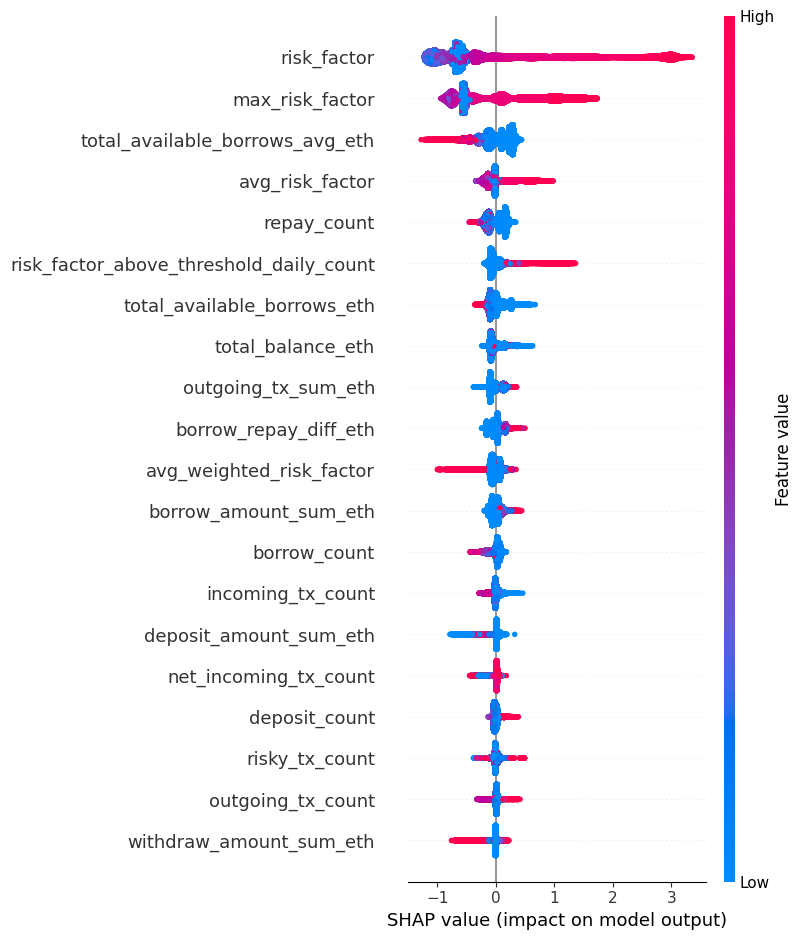

In [18]:
# Visualizar el resumen de SHAP values
shap.summary_plot(shap_values, X_t1)
